In [1]:
!pip install -U dicomsdl

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.0 MB/s eta 0:00:00


In [2]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
from tqdm import tqdm
import pydicom
import dicomsdl as dicoml
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf

import warnings
warnings.filterwarnings('ignore')

In [3]:
def set_seed(seed):
    np.random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)

In [4]:
train_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/train.csv")
test_df = pd.read_csv("/kaggle/input/rsna-breast-cancer-detection/test.csv")

train_dir = '/kaggle/input/rsna-breast-cancer-detection/train_images/'
test_dir = '/kaggle/input/rsna-breast-cancer-detection/test_images/'

In [5]:
train_images = glob.glob("/kaggle/input/rsna-breast-cancer-detection/train_images/*/*.dcm")

len(train_images) 

54706

In [6]:
RESIZE_TO = (224, 224)

!rm -rf train_images_processed_cv2_dicomsdl_{RESIZE_TO[0]}
!mkdir train_images_processed_cv2_dicomsdl_{RESIZE_TO[0]}

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)


In [7]:
def extract_roi(image):
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.uint8)
    else:
        gray = image.astype(np.uint8)

#     ret, gray = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)
#     gray = cv2.morphologyEx(gray, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (128, 128)))
#     gray = cv2.bitwise_not(gray)
    
    contours, hierarchy = cv2.findContours(gray, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contour = max(contours, key = cv2.contourArea)
    
    x, y, w, h = cv2.boundingRect(contour)
    roi = image[y: y + h, x: x + w]

    return roi


def resize_image(image, width=None, height=None, inter=cv2.INTER_LINEAR):
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image

    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)    
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    image = cv2.resize(image, dim, interpolation=inter)

    return image


def read_dicom(path, image_size=None, fix_monochrome=True, keep_aspect_ratio=True, crop_roi=True):

    dicom = dicoml.open(str(path))
    data = dicom.pixelData()

    if fix_monochrome and dicom.PhotometricInterpretation == 'MONOCHROME1':
        data = np.amax(data) - data
    
    if crop_roi:
        data = extract_roi(data)
        
    data = (data - data.min()) / (data.max() - data.min())
    data = (data * 255).astype(np.uint8)
#     data = cv2.cvtColor(data, cv2.COLOR_GRAY2RGB)
    data = cv2.resize(data, (224, 224))
    data = np.stack((data,)*3, axis=-1)

    return data

Image shape:  (224, 224, 3)
0.797236442565918


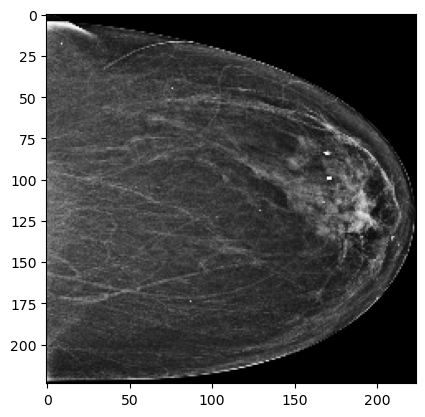

In [8]:
import time
st = time.time()

image_size = 224
fix_monochrome = True
keep_aspect_ratio = False
crop_roi = True
path = '/kaggle/input/rsna-breast-cancer-detection/train_images/10130/1013166704.dcm'

image = read_dicom(path, image_size, fix_monochrome, keep_aspect_ratio, crop_roi)
print('Image shape: ', image.shape)
plt.imshow(image)
print(time.time() - st)

In [9]:
directories = list(Path('/kaggle/input/rsna-breast-cancer-detection/train_images/').iterdir())
print(len(directories))

11913


In [11]:
# st = time.time()
directories = list(Path('/kaggle/input/rsna-breast-cancer-detection/train_images/').iterdir())

def process_directory(directory_path):
    parent_directory = str(directory_path).split('/')[-1]
    !mkdir -p train_images_processed_cv2_dicomsdl_{RESIZE_TO[0]}/{parent_directory}
    for image_path in directory_path.iterdir():
        processed_ary = read_dicom(image_path)
        
        cv2.imwrite(
            f'train_images_processed_cv2_dicomsdl_{RESIZE_TO[0]}/{parent_directory}/{image_path.stem}.png',
            processed_ary
        )
        
import multiprocessing as mp

with mp.Pool(8) as p:
    p.map(process_directory, directories)
    
# print(time.time() - st)

/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/conda/lib/libtinfo.so.6: no version information available (required by /bin/bash)
/bin/bash: /opt/cond